In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from Lesson6 import DecisionTreeRegressor

In [54]:
def calc_mse(y, y_pred):
  return np.mean((y - y_pred)**2)


def bias(y, z):
    return y - z


class GBoost:

    def __init__(self, n_trees, max_depth, coefs, eta, stohastic=1.0):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.stohastic = stohastic
        self.trees = []
        self.train_errors = []
        self.test_errors = []
    
    def fit_predict(self, X_train, X_test, y_train, y_test):

        for i in range(self.n_trees):

            indx_train = np.random.randint(0, X_train.shape[0],
                                           int(X_train.shape[0] * self.stohastic))
            indx_test = np.random.randint(0, X_test.shape[0],
                                          int(X_test.shape[0] * self.stohastic))
            X_train_st = X_train[indx_train, :]
            X_test_st = X_test[indx_test, :]
            y_train_st = y_train[indx_train]
            y_test_st = y_test[indx_test]

            tree = DecisionTreeRegressor(min_leaf=5, max_leafs=1000, max_nodes=max_depth)
            if len(self.trees) == 0:
                tree.fit(X_train_st, y_train_st)
                self.train_errors.append(calc_mse(y_train_st, self.gb_predict(X_train_st)))
                self.test_errors.append(calc_mse(y_test_st, self.gb_predict(X_test_st)))
            else:
                target = self.gb_predict(X_train_st)
                tree.fit(X_train_st, bias(y_train_st, target))
                self.train_errors.append(calc_mse(y_train_st, self.gb_predict(X_train_st)))
                self.test_errors.append(calc_mse(y_test_st, self.gb_predict(X_test_st)))
            self.trees.append(tree)

    def gb_predict(self, X):
        return np.array([sum([self.eta * coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])

In [55]:
X, y = datasets.load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [56]:
n_trees = 30
coefs = [1] * n_trees
boost_list = []
for max_depth in [1, 5, 10, 25]:
    for eta in [1, 0.1, 0.05]:
        boost = GBoost(n_trees, max_depth, coefs, eta, stohastic=0.5)
        boost.fit_predict(X_train, X_test, y_train, y_test)
        boost_list.append((max_depth, eta, boost.test_errors[-1]))

In [57]:
boost_list = np.array(boost_list)

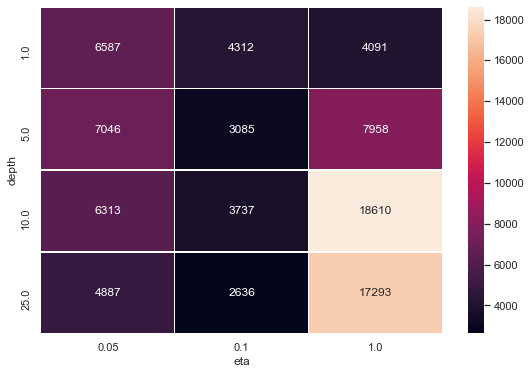

In [58]:
df = pd.DataFrame(data=boost_list, columns=['depth', 'eta', 'MSE'])
df.MSE = df.MSE.astype(int)
errors = df.pivot('depth', 'eta', 'MSE')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(errors, annot=True, fmt="d", linewidths=.5, ax=ax)


In [62]:
def get_error_plot(boost1, boost2):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    n_trees = boost1.n_trees
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), boost1.train_errors, label='simple')
    plt.plot(list(range(n_trees)), boost2.test_errors, label='stochastic 0.5')
    plt.legend(loc='upper right')
    plt.show()

In [60]:
n_trees = 50
coefs = [1] * n_trees
max_depth = 10
eta = 0.1

boost_1 = GBoost(n_trees, max_depth, coefs, eta, stohastic=1)
boost_1.fit_predict(X_train, X_test, y_train, y_test)

boost_05 = GBoost(n_trees, max_depth, coefs, eta, stohastic=0.5)
boost_05.fit_predict(X_train, X_test, y_train, y_test)

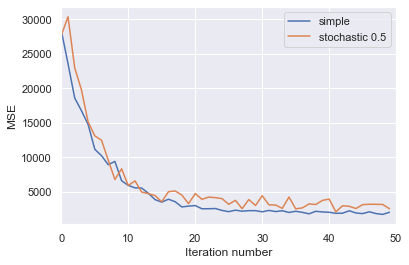

In [63]:
get_error_plot(boost_1, boost_05)